In [1]:
import os
from tqdm.auto import tqdm
import re
from scipy.spatial import distance

In [2]:
os.listdir('Projects/pb-stylistic/ridero10')

['raw_chunks',
 'katrina_aleksei_kondratenko.txt',
 '.ipynb_checkpoints',
 'barmen_iz_sheremetevo_aleksandr_kuprin.txt',
 'itigirgin_ka_terina.txt',
 'batches',
 'wv.txt',
 'polka',
 'yashik_pandori_nazar_valeev.txt',
 'chunks_processed',
 'akademiya_magii_oksana_ivchenko.txt',
 '3_storoni_markus_whels.txt',
 'oshibka_xonomobe.txt',
 'brat_alisa_atreidas.txt',
 'izumrud_teni_proshlogo_mary_jane.txt']

In [2]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [3]:
from collections import Counter

In [4]:
import pandas as pd
import numpy as np
polka_catalog = pd.read_csv('collection_catalog_full_final.csv', sep=';', )[['book_title', 'fbusta_id']]

In [48]:
polka_catalog

,book_title,fbusta_id
0,Братья и сестры,158030
1,Две зимы и три лета,158033
2,Пути-перепутья,158036
3,Дом,158032
4,Дюжина ножей в спину революции,159215
...,...,...
639,Заговор равных,391821
640,Казароза,119201
641,Костюм Арлекина,24680
642,Князь ветра,76325


In [53]:
dir_in = 'txt_cut'
dir_out = 'ridero10/polka/raw_chunks'

os.mkdir('ridero10/polka')
os.mkdir(dir_out)
for name in tqdm(os.listdir(dir_in)):
    if name.startswith('.') or name == 'raw_chunks':
        continue
    with open(os.path.join(dir_in, name)) as f:
        content = f.read().strip()
        content = content.replace('?..', '?').replace('!..', '!').replace('...', '…').replace('--', '–')
        content = re.sub('[…]+', ' … ', content)
        content = re.sub('\s+', ' ', content)
        content = re.sub('[_]+', '_', content)
        content = re.sub('[\n]+', ' \n ', content)
        content = re.sub('[*]+', '*', content)
        content = re.sub('\xa0', ' ', content)
        text = content.split(' ')
        for i, chunk in enumerate(chunks(text, 1050)):
            if len(chunk) < 500:
                continue
            with open(os.path.join(dir_out, name + f'_{i}'), 'w') as ff:
                ff.write(' '.join(chunk))

In [54]:
os.mkdir('ridero10/polka/chunks_processed')
for i in tqdm(os.listdir(dir_out)):
    !~/Projects/pb-stylistic/mystem --format=text -wnld ~/Projects/pb-stylistic/ridero10/polka/raw_chunks/{i} ~/Projects/pb-stylistic/ridero10/polka/chunks_processed/{i}

In [5]:
os.chdir('Projects/pb-stylistic')

In [6]:
import artm
models = []
for i in range(1, 8):
    models.append(artm.load_artm_model(f'S_topics_{i}00'))

In [15]:
ids = []
with open(f'ridero10/polka/wv.txt', 'w') as f1:
    i = 0
    for f in tqdm(sorted(os.listdir(f'ridero10/polka/chunks_processed/'))):
        with open(f'ridero10/polka/chunks_processed/' + f) as doc:
            tokens = doc.read().replace('?', '').replace('\n', ' ').split()
            doc_voc = Counter(tokens)
            s = ' '.join(f'{w}:{c}' for w, c in sorted(doc_voc.items()))
            row = f'{f.replace(" ", "_").replace(":", "")} {s}\n'
            f1.write(row)
            ids.append(f)

In [17]:
ids_ridero10 = []
with open(f'ridero10/wv.txt', 'w') as f1:
    i = 0
    for f in tqdm(sorted(os.listdir(f'ridero10/chunks_processed/'))):
        with open(f'ridero10/chunks_processed/' + f) as doc:
            tokens = doc.read().replace('?', '').replace('\n', ' ').split()
            doc_voc = Counter(tokens)
            s = ' '.join(f'{w}:{c}' for w, c in sorted(doc_voc.items()))
            row = f'{f.replace(" ", "_").replace(":", "")} {s}\n'
            f1.write(row)
            ids_ridero10.append(f)

In [7]:
polka_batch_vectorizer = artm.BatchVectorizer(data_path=f'ridero10/polka/wv.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder=f'ridero10/polka/batches')

In [8]:
ridero10_batch_vectorizer = artm.BatchVectorizer(data_path=f'ridero10/wv.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder=f'ridero10/batches')

In [9]:
polka = models[3].transform(polka_batch_vectorizer)

In [10]:
ridero10 = models[3].transform(ridero10_batch_vectorizer)

In [11]:
distances = distance.cdist(ridero10.T, polka.T, metric=distance.jensenshannon)

In [133]:
model_tokens = models[3].score_tracker['TopTokensScore10'].last_tokens

In [176]:
%matplotlib inline

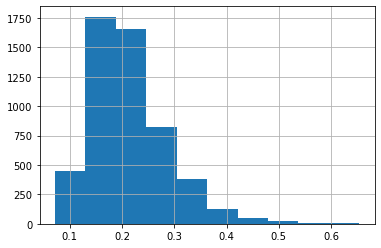

In [183]:
models[3].transform(polka_batch_vectorizer).T.apply(lambda x: sum(sorted(x)[-3:]), axis=1).hist()

In [12]:
qq = models[3].transform(polka_batch_vectorizer).T.apply(lambda x: sum(sorted(x)[-3:]), axis=1)

In [13]:
qq.sort_values()

2246    0.071530
1874    0.075670
3975    0.076854
2152    0.077236
3972    0.077853
          ...   
2937    0.596551
2380    0.603063
4777    0.616054
420     0.638732
4775    0.654054
Length: 5293, dtype: float64

In [197]:
ids[4775]

'70498.fb2.txt_0'

In [201]:
polka.T.loc[4775].sort_values()

topic_0      0.000000
topic_265    0.000000
topic_263    0.000000
topic_262    0.000000
topic_260    0.000000
               ...   
topic_251    0.029270
topic_307    0.031126
topic_13     0.033154
topic_149    0.049164
topic_393    0.571737
Name: 4775, Length: 400, dtype: float32

In [21]:
model_tokens = models[3].score_tracker['TopTokensScore10'].last_tokens

In [206]:
model_tokens['topic_393']

['весть',
 'кролик',
 'горожанин',
 'гонец',
 'укрепление',
 'осада',
 'удав',
 'бойница',
 'огрызок',
 'бастион']

In [188]:
polka.T

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_390,topic_391,topic_392,topic_393,topic_394,topic_395,topic_396,topic_397,topic_398,topic_399
4000,0.000000,0.000000,0.012957,0.012213,0.013846,0.000000,0.0,0.000000,0.005830,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4001,0.008439,0.006097,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.007160,0.0
4002,0.006508,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.013222,0.0,...,0.00000,0.000000,0.012436,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4003,0.036894,0.000000,0.005506,0.006669,0.000000,0.005577,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.009485,0.0,0.0,0.000000,0.0
4004,0.032039,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.00000,0.006621,0.000000,0.0,0.0,0.001721,0.0,0.0,0.016688,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.000000,0.011486,0.005468,0.006346,0.000000,0.000000,0.0,0.000000,0.017181,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.012654,0.0
3996,0.000000,0.000000,0.022919,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.005505,0.0,0.0,0.000000,0.0,0.0,0.005675,0.0
3997,0.007176,0.005962,0.000000,0.000000,0.013554,0.000000,0.0,0.006004,0.007545,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.014017,0.0
3998,0.006346,0.000000,0.000000,0.011861,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.006453,0.0


In [14]:
import shutil
# shutil.copy('/etc/hostname', '/var/tmp/testhostname')

In [18]:
for i, idxes in enumerate(distances.argsort()[:, [0, len(distances[0]) // 2, len(distances[0])-1]]):
    if ids_ridero10[i].endswith('_1'):
        try:
            os.mkdir(f'ridero10/evaluation')
        except:
            pass
        try:
            os.mkdir(f'ridero10/evaluation/{i}')
        except:
            pass
        shutil.copy(f'ridero10/raw_chunks/{ids_ridero10[i]}', f'ridero10/evaluation/{i}/{ids_ridero10[i]}_.txt')
        for j, idx in enumerate(idxes):
            shutil.copy(f'ridero10/polka/raw_chunks/{ids[idx]}', f'ridero10/evaluation/{i}/{j}_.txt')
            
            
        
    
#     print(i, ids_ridero10[i])
#     for t, w in ridero10.T.iloc[i].sort_values()[-3:].items():
#         print(f'{round(w, 3)}*{t}:{" ".join(model_tokens[t][:8])}')
#     print('Most similar to:', idx, ids[idx])
#     for t, w in polka.T.iloc[idx].sort_values()[-3:].items():
#         print(f'{round(w, 3)}*{t}:{" ".join(model_tokens[t][:8])}')
#     print('similarity:', round(distances[i][idx], 3))
#     print()

468939.fb2.txt_6
143082.fb2.txt_7
28799.fb2.txt_3
169333.fb2.txt_0
24680.fb2.txt_1
185862.fb2.txt_7
76721.fb2.txt_5
232264.fb2.txt_5
185965.fb2.txt_6
173143.fb2.txt_5
441225.fb2.txt_1
58521.fb2.txt_8
160794.fb2.txt_7
173155.fb2.txt_7
183128.fb2.txt_3
168343.fb2.txt_3
225656.fb2.txt_5
343914.fb2.txt_4
320065.fb2.txt_7
50901.fb2.txt_1
497239.fb2.txt_0
133556.fb2.txt_0
317595.fb2.txt_4
239744.fb2.txt_6
133556.fb2.txt_2
365649.fb2.txt_1
376834.fb2.txt_3


In [30]:
distances.argsort()[:, 0]

array([5120, 4167, 1612, 2299, 3856, 4526, 3255, 1115, 2725, 1906,  902,
       2725, 2027, 2089, 4610, 3439, 2799, 2597, 3241, 3252, 3053,  408,
       1459, 4340, 3406, 2869,  317, 4498,  842, 4301, 2706, 2673, 2673,
       3913, 4606, 2680, 2675, 2680, 2678])

In [166]:
for i, idx in enumerate(distances.argsort()[:,0]):
    print(i, ids_ridero10[i])
    for t, w in ridero10.T.iloc[i].sort_values()[-3:].items():
        print(f'{round(w, 3)}*{t}:{" ".join(model_tokens[t][:8])}')
    print('Most similar to:', idx, ids[idx])
    for t, w in polka.T.iloc[idx].sort_values()[-3:].items():
        print(f'{round(w, 3)}*{t}:{" ".join(model_tokens[t][:8])}')
    print('similarity:', round(distances[i][idx], 3))
    print()

0 3_storoni_markus_whels.txt_0
0.035*topic_129:меч плащ рыцарь клинок ножны доспехи шпага герб
0.04*topic_51:отряд район пост территория банда патруль крым украина
0.086*topic_326:королева наследник королевство потомок дворянин интрига братство покровитель
Most similar to: 3120 35519.fb2.txt_0
0.049*topic_99:офицер армия полк военный гвардия штык парад войско
0.095*topic_61:противник атака позиция разведчик орудие пулемет батарея маневр
0.104*topic_114:изба казак верста татарин сотник сени атаман хутор
similarity: 0.665

1 3_storoni_markus_whels.txt_1
0.062*topic_138:мяч тренировка спорт сетка соперник тренер упражнение соревнование
0.062*topic_129:меч плащ рыцарь клинок ножны доспехи шпага герб
0.07*topic_158:мак цирк трюк арена фитиль саванна панама пятак
Most similar to: 874 158230.fb2.txt_7
0.045*topic_326:королева наследник королевство потомок дворянин интрига братство покровитель
0.065*topic_158:мак цирк трюк арена фитиль саванна панама пятак
0.108*topic_144:директор сцена публик